# Parallel execution

In this tutorial, we are interested to run the model not only for the default initial conditions, but for N different initial conditions. 

For examples, we will see how we can compute/visualize the phase space trajectories of a GRN with 3 nodes, and how a simply vmap allows to do that.

## Imports and Utils

In [1]:
import importlib
from itertools import combinations

import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
from jax import vmap

import matplotlib.pylab as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.transforms import Affine2D, offset_copy
from sbmltoodejax.biomodels_api import get_content_for_model
from sbmltoodejax.modulegeneration import GenerateModel
from sbmltoodejax.parse import ParseSBMLFile

### Load utils

In [2]:
def generate_model(model_idx, deltaT=0.1, atol=1e-6, rtol=1e-12):
    model_fp = "jax_model.py"
    model_xml_body = get_content_for_model(model_idx)
    model_data = ParseSBMLFile(model_xml_body)
    GenerateModel(model_data, model_fp, deltaT=deltaT, atol=atol, rtol=rtol)
    
    return model_fp

def load_model(model_idx, deltaT=0.1, atol=1e-6, rtol=1e-12):
    model_fp = generate_model(model_idx, deltaT=deltaT, atol=atol, rtol=rtol)
    spec = importlib.util.spec_from_file_location("JaxModelSpec", model_fp)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    model_cls = getattr(module, "ModelRollout")
    model = model_cls()
    y0 = getattr(module, "y0")
    w0 = getattr(module, "w0")

    return model, y0, w0

### Plot utils

In [3]:
# default colors
default_colors = [(204,121,167), 
                  (0,114,178),
                  (230,159,0),  
                  (0,158,115),
                  (127,127,127),
                  (240,228,66),
                  (148,103,189),
                  (86,180,233),
                  (213,94,0),
                  (140,86,75),
                  (214,39,40),
                  (0,0,0)]
default_colors = [tuple([c/255 for c in color]) for color in default_colors]

In [4]:
def plot_time_trajectory(times, ys, y_indexes):
    plt.figure(figsize=(6, 4))
    for y_label, y_idx in y_indexes.items():
        plt.plot(times, ys[y_idx, :], color=default_colors[y_idx], label=y_label)
    plt.legend()
    plt.show()

In [5]:
def plot_phase_space_trajectories(ys, y_indexes, plot_every=1):

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    
    X = ys[..., 0, :-1][..., ::plot_every]
    Y = ys[..., 1, :-1][..., ::plot_every]
    Z = ys[..., 2, :-1][..., ::plot_every]
    U = ys[..., 0, 1:][..., ::plot_every] - X
    V = ys[..., 1, 1:][..., ::plot_every] - Y
    W = ys[..., 2, 1:][..., ::plot_every] - Z
    
    T = X.shape[-1]
    if X.ndim == 2:
        batch_size = X.shape[0]
    else:
        batch_size = 1
    c = ([hsv_to_rgb((step / (2*T), 1, 1)) for step in range(T)][::plot_every])*batch_size
    ax.quiver(X.flatten(), Y.flatten(), Z.flatten(), 
              U.flatten(), V.flatten(), W.flatten(), 
              color=c, arrow_length_ratio=0)

    for y_name, y_idx in y_indexes.items():
        if y_idx == 0:
            ax.set_xlabel(y_name)
        elif y_idx == 1:
            ax.set_ylabel(y_name)
        elif y_idx == 2:
            ax.set_zlabel(y_name)
    plt.show()

### Logo Utils

In [6]:
# Taken from https://matplotlib.org/stable/gallery/text_labels_and_annotations/rainbow_text.html
def rainbow_text(x, y, strings, colors, orientation='horizontal', ax=None, **kwargs):
    """
    Take a list of *strings* and *colors* and place them next to each
    other, with text strings[i] being shown in colors[i].

    Parameters
    ----------
    x, y : float
        Text position in data coordinates.
    strings : list of str
        The strings to draw.
    colors : list of color
        The colors to use.
    orientation : {'horizontal', 'vertical'}
    ax : Axes, optional
        The Axes to draw into. If None, the current axes will be used.
    **kwargs
        All other keyword arguments are passed to plt.text(), so you can
        set the font size, family, etc.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    fig = ax.figure
    canvas = fig.canvas

    assert orientation in ['horizontal', 'vertical']
    if orientation == 'vertical':
        kwargs.update(rotation=90, verticalalignment='bottom')

    for s, c in zip(strings, colors):
        text = ax.text(x, y, s + " ", color=c, transform=t, **kwargs)

        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        # Convert window extent from pixels to inches
        # to avoid issues displaying at different dpi
        ex = fig.dpi_scale_trans.inverted().transform_bbox(ex)

        if orientation == 'horizontal':
            t = text.get_transform() + \
                offset_copy(Affine2D(), fig=fig, x=ex.width*0.65, y=0)
        else:
            t = text.get_transform() + \
                offset_copy(Affine2D(), fig=fig, x=0, y=ex.height)

def generate_logo(times, y1, y2):
    T = len(times)
    c = [hsv_to_rgb((step / (2*T), 1, 1)) for step in range(T)]
    x = y1[:-1]
    y = y2[:-1]
    u = y1[1:] - x
    v = y2[1:] - y
    fig = plt.figure(figsize=(7,4))
    plt.quiver(x, y, u, v, color=c, alpha=.7, angles='xy', scale_units='xy', scale=1, headaxislength=2)
    text_colors = [c[pos] for pos in range(0, len(c)//2, len(c)//len("SBML to ODE jax")//2)][::-1]
    rainbow_text(0.405, 0.35, [c for c in "SBML to ODE jax"[:11]], text_colors[:11], orientation='horizontal', size=20, weight="heavy")
    rainbow_text(0.5, 0.25, [c for c in "SBML to ODE jax"[11:]], text_colors[11:], orientation='horizontal', size=20, weight="heavy")
    plt.axis("off")
    plt.show()

## Default trajectory in phase space

In [7]:
n_secs = 100
model_idx = 156 #191

In [8]:
model, default_y0, default_w0 = load_model(model_idx)
default_ys, default_ws, times = model(int(n_secs / model.deltaT))

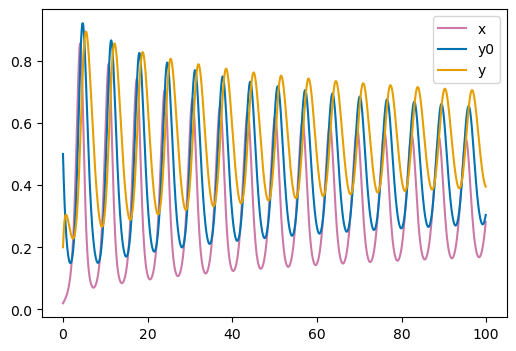

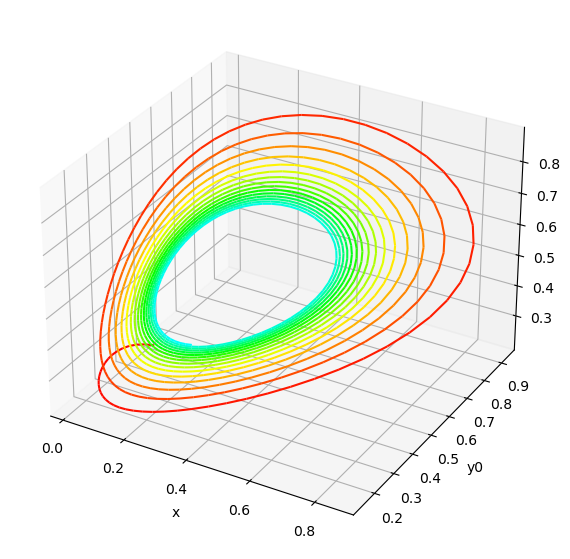

In [9]:
plot_time_trajectory(times, default_ys, model.modelstepfunc.y_indexes)
plot_phase_space_trajectories(default_ys, model.modelstepfunc.y_indexes)

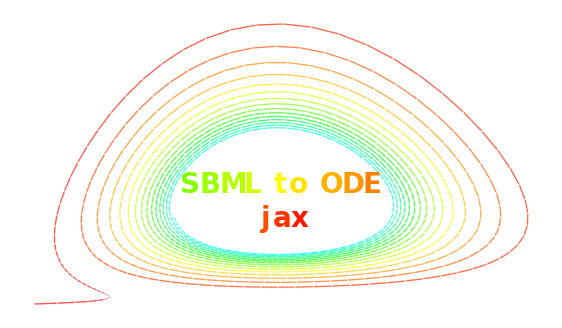

In [10]:
generate_logo(times, default_ys[2], default_ys[0])

## Batch mode

In [11]:
r=5
ymin = 1/r * default_ys.min(-1)
ymax = r * default_ys.max(-1)

In [12]:
batched_model = vmap(model, in_axes=(None, 0, 0), out_axes=(0, 0, None))

In [13]:
n_inits_per_dim = 4
grid = jnp.meshgrid(
    *[
        jnp.linspace(ymin[node_idx], ymax[node_idx], n_inits_per_dim)
        for node_idx in range(len(ymin))
    ]
)
y0 = jnp.stack([dim_grid.flatten() for dim_grid in grid], axis=-1)
w0 = jnp.repeat(default_w0[jnp.newaxis], y0.shape[0], axis=0)

In [14]:
ys, ws, times = batched_model(int(n_secs / model.deltaT), y0, w0)

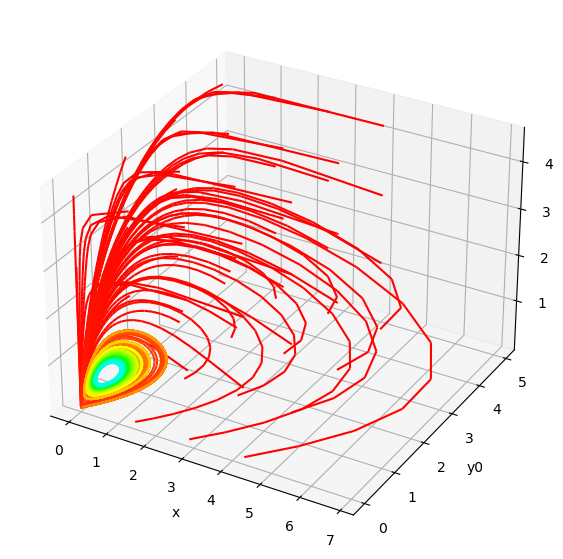

In [15]:
plot_phase_space_trajectories(ys, model.modelstepfunc.y_indexes)